<a href="https://colab.research.google.com/github/abulmeez/ML_Projects/blob/main/final4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


#1: Data Preprocessing

In [ ]:
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions")

# Inspect the dataset
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [ ]:
# Filter out examples with multiple labels
def filter_single_label(example):
    return len(example['labels']) == 1

filtered_dataset = dataset.filter(filter_single_label)

# Inspect the filtered dataset
print(filtered_dataset)


Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 36308
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 4548
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 4590
    })
})


In [ ]:
train_data = filtered_dataset["train"]
val_data = filtered_dataset["validation"]
test_data = filtered_dataset["test"]

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 36308, Validation size: 4548, Test size: 4590


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract texts and labels for baseline model
train_texts = [example['text'] for example in train_data]
train_labels = [example['labels'][0] for example in train_data]

val_texts = [example['text'] for example in val_data]
val_labels = [example['labels'][0] for example in val_data]

test_texts = [example['text'] for example in test_data]
test_labels = [example['labels'][0] for example in test_data]

# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features based on memory limits
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

print("TF-IDF preprocessing complete.")


TF-IDF preprocessing complete.


In [ ]:
from transformers import AutoTokenizer

# Load tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

print("Tokenization complete.")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenization complete.


In [ ]:
import pickle

# Save the TF-IDF vectors and labels
with open("tfidf_data.pkl", "wb") as f:
    pickle.dump((X_train, train_labels, X_val, val_labels, X_test, test_labels), f)

# Save the tokenized data
with open("tokenized_data.pkl", "wb") as f:
    pickle.dump((train_encodings, train_labels, val_encodings, val_labels, test_encodings, test_labels), f)

print("Preprocessed data saved.")


Preprocessed data saved.


#2.1: Implementing Naive Bayes Model

In [ ]:
import numpy as np

class NaiveBayesClassifier:
    def __init__(self):
        self.prior = None  # P(class)
        self.likelihood = None  # P(feature|class)
        self.classes = None  # Unique classes (labels)
        self.feature_log_prob = None  # Log probabilities for numerical stability

    def fit(self, X, y):
        """
        Train the Naive Bayes model.
        :param X: Feature matrix (TF-IDF)
        :param y: Target labels
        """
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Initialize prior and likelihood arrays
        self.prior = np.zeros(n_classes, dtype=np.float64)
        self.likelihood = np.zeros((n_classes, n_features), dtype=np.float64)

        for idx, cls in enumerate(self.classes):
            # Extract samples belonging to the current class
            X_cls = X[np.array(y) == cls]

            # Compute prior probabilities
            self.prior[idx] = X_cls.shape[0] / n_samples

            # Compute likelihood (using Laplace smoothing)
            self.likelihood[idx, :] = (X_cls.sum(axis=0) + 1) / (X_cls.sum() + n_features)

        # Convert likelihood to log probabilities for numerical stability
        self.feature_log_prob = np.log(self.likelihood)
        self.prior = np.log(self.prior)

    def predict(self, X):
        """
        Predict class labels for input data.
        :param X: Feature matrix (TF-IDF)
        :return: Predicted labels
        """
        # Compute the posterior log probability
        log_posteriors = X @ self.feature_log_prob.T + self.prior
        return self.classes[np.argmax(log_posteriors, axis=1)]

    def evaluate_accuracy(self, X, y):
        """
        Evaluate accuracy of the model.
        :param X: Feature matrix (TF-IDF)
        :param y: True labels
        :return: Accuracy score
        """
        predictions = self.predict(X)
        return np.mean(predictions == y)


In [ ]:
# Initialize and train the model
nb_model = NaiveBayesClassifier()
nb_model.fit(X_train, train_labels)

print("Naive Bayes model trained successfully!")


Naive Bayes model trained successfully!


In [ ]:
# Evaluate accuracy on validation and test sets
val_accuracy = nb_model.evaluate_accuracy(X_val, val_labels)
test_accuracy = nb_model.evaluate_accuracy(X_test, test_labels)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.4059
Test Accuracy: 0.4033


#2.2: Fine-tuning LLM (bert-base-uncased)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and pretrained BERT model
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

# Load the model for sequence classification with an uninitialized classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=28,  # 27 emotions + Neutral
)

# Set model to evaluation mode
model.eval()

print("Pretrained BERT model loaded successfully!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained BERT model loaded successfully!


In [ ]:
# Tokenize the validation and test sets
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Convert labels to PyTorch tensors
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

print("Tokenization complete.")


Tokenization complete.


Evaluating pre-trained model

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Create DataLoader for validation and test sets
val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels_tensor)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels_tensor)

val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

def evaluate(model, data_loader):
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return accuracy_score(true_labels, predictions)

# Evaluate on validation and test sets
val_accuracy = evaluate(model, val_loader)
test_accuracy = evaluate(model, test_loader)

print(f"Validation Accuracy (Pretrained): {val_accuracy:.4f}")
print(f"Test Accuracy (Pretrained): {test_accuracy:.4f}")

Validation Accuracy (Pretrained): 0.0237
Test Accuracy (Pretrained): 0.0205


Evaluating last-layer in pre-trained model

In [ ]:
# Freeze all parameters in the model
for param in model.base_model.parameters():
    param.requires_grad = False


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import torch

# Ensure the model is in evaluation mode and moved to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Create DataLoader for validation and test sets
val_dataset = TensorDataset(
    val_encodings["input_ids"], val_encodings["attention_mask"], val_labels_tensor
)
test_dataset = TensorDataset(
    test_encodings["input_ids"], test_encodings["attention_mask"], test_labels_tensor
)

val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define evaluation function
def evaluate_last_layer(model, data_loader, device):
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Perform forward pass using only the last layer
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predictions
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return accuracy_score(true_labels, predictions)

# Evaluate on validation and test sets
val_accuracy = evaluate_last_layer(model, val_loader, device)
test_accuracy = evaluate_last_layer(model, test_loader, device)

print(f"Validation Accuracy (Pretrained): {val_accuracy:.4f}")
print(f"Test Accuracy (Pretrained): {test_accuracy:.4f}")


Validation Accuracy (Pretrained): 0.0237
Test Accuracy (Pretrained): 0.0205


Fine-tuning model

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert inputs and labels to tensors
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
train_labels_tensor = torch.tensor(train_labels)

# Create a dataset and DataLoader for training
train_dataset = TensorDataset(
    train_encodings["input_ids"], train_encodings["attention_mask"], train_labels_tensor
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Validation DataLoader (reuse val_encodings and val_labels_tensor from previous steps)
val_dataset = TensorDataset(
    val_encodings["input_ids"], val_encodings["attention_mask"], val_labels_tensor
)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss
import torch

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# Training loop
def train_model(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Training
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss
            loss = loss_fn(logits, labels)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training Loss: {train_loss/len(train_loader):.4f}")
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
        print(f"Validation Accuracy: {correct/total:.4f}")


In [ ]:
train_model(model, train_loader, val_loader, epochs=3)

Epoch 1/3
Training Loss: 2.6155
Validation Loss: 2.5513
Validation Accuracy: 0.3500
Epoch 2/3
Training Loss: 2.5413
Validation Loss: 2.5049
Validation Accuracy: 0.3500
Epoch 3/3
Training Loss: 2.5022
Validation Loss: 2.4728
Validation Accuracy: 0.3500


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Fine-Tuning: {test_accuracy:.4f}")


Test Accuracy after Fine-Tuning: 0.3499


In [ ]:
# Define hyperparameters
learning_rate = 2e-5
train_batch_size = 16
eval_batch_size = 16
num_epochs = 3
seed = 42

# Set seed for reproducibility
import torch
import numpy as np
import random

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [ ]:
from transformers import get_scheduler

# Initialize optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8
)

# Define the learning rate scheduler
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


In [ ]:
from tqdm import tqdm

# Training loop
def train_model(model, train_loader, val_loader, optimizer, lr_scheduler, epochs):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Training phase
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        # Log epoch results
        val_accuracy = correct / total
        print(f"Epoch {epoch+1}:")
        print(f"  Training Loss: {train_loss/len(train_loader):.4f}")
        print(f"  Validation Loss: {val_loss/len(val_loader):.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")


In [ ]:
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs)

Epoch 1/3: 100%|██████████| 2270/2270 [04:09<00:00,  9.09it/s]


Epoch 1:
  Training Loss: 2.4784
  Validation Loss: 2.4552
  Validation Accuracy: 0.3500


Epoch 2/3: 100%|██████████| 2270/2270 [04:08<00:00,  9.15it/s]


Epoch 2:
  Training Loss: 2.4684
  Validation Loss: 2.4476
  Validation Accuracy: 0.3500


Epoch 3/3: 100%|██████████| 2270/2270 [04:07<00:00,  9.16it/s]


Epoch 3:
  Training Loss: 2.4622
  Validation Loss: 2.4450
  Validation Accuracy: 0.3500


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Fine-Tuning: {test_accuracy:.4f}")


Test Accuracy after Fine-Tuning: 0.3499


In [ ]:
import torch.nn as nn

# Reinitialize the classification head
def reinitialize_classification_head(model):
    for layer in model.classifier.children():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()
    print("Classification head reinitialized.")

reinitialize_classification_head(model)


Classification head reinitialized.


In [ ]:
# Fine-tune the model
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs)


Epoch 1/3: 100%|██████████| 2270/2270 [04:08<00:00,  9.12it/s]


Epoch 1:
  Training Loss: 2.4631
  Validation Loss: 2.4450
  Validation Accuracy: 0.3500


Epoch 2/3: 100%|██████████| 2270/2270 [04:07<00:00,  9.18it/s]


Epoch 2:
  Training Loss: 2.4617
  Validation Loss: 2.4450
  Validation Accuracy: 0.3500


Epoch 3/3: 100%|██████████| 2270/2270 [04:07<00:00,  9.18it/s]


Epoch 3:
  Training Loss: 2.4627
  Validation Loss: 2.4450
  Validation Accuracy: 0.3500


In [ ]:
# Evaluate the fine-tuned model
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Warm-Start Fine-Tuning: {test_accuracy:.4f}")


Test Accuracy after Warm-Start Fine-Tuning: 0.3499


In [ ]:
# Unfreeze the last two transformer layers
for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# Verify that only the last two layers and the classification head are trainable
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


bert.embeddings.word_embeddings.weight: Frozen
bert.embeddings.position_embeddings.weight: Frozen
bert.embeddings.token_type_embeddings.weight: Frozen
bert.embeddings.LayerNorm.weight: Frozen
bert.embeddings.LayerNorm.bias: Frozen
bert.encoder.layer.0.attention.self.query.weight: Frozen
bert.encoder.layer.0.attention.self.query.bias: Frozen
bert.encoder.layer.0.attention.self.key.weight: Frozen
bert.encoder.layer.0.attention.self.key.bias: Frozen
bert.encoder.layer.0.attention.self.value.weight: Frozen
bert.encoder.layer.0.attention.self.value.bias: Frozen
bert.encoder.layer.0.attention.output.dense.weight: Frozen
bert.encoder.layer.0.attention.output.dense.bias: Frozen
bert.encoder.layer.0.attention.output.LayerNorm.weight: Frozen
bert.encoder.layer.0.attention.output.LayerNorm.bias: Frozen
bert.encoder.layer.0.intermediate.dense.weight: Frozen
bert.encoder.layer.0.intermediate.dense.bias: Frozen
bert.encoder.layer.0.output.dense.weight: Frozen
bert.encoder.layer.0.output.dense.bias: 

In [ ]:
# Define optimizer for only trainable parameters
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5,  # Learning rate
    betas=(0.9, 0.999),
    eps=1e-8
)


In [ ]:
# Fine-tune the model
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, num_epochs)


Epoch 1/3: 100%|██████████| 2270/2270 [05:18<00:00,  7.14it/s]


Epoch 1:
  Training Loss: 1.7588
  Validation Loss: 1.4533
  Validation Accuracy: 0.5836


Epoch 2/3: 100%|██████████| 2270/2270 [05:16<00:00,  7.16it/s]


Epoch 2:
  Training Loss: 1.4284
  Validation Loss: 1.3724
  Validation Accuracy: 0.5917


Epoch 3/3: 100%|██████████| 2270/2270 [05:17<00:00,  7.16it/s]


Epoch 3:
  Training Loss: 1.3184
  Validation Loss: 1.3176
  Validation Accuracy: 0.6071


In [ ]:
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Fine-Tuning Last Two Layers: {test_accuracy:.4f}")


Test Accuracy after Fine-Tuning Last Two Layers: 0.6098


In [ ]:
# Unfreeze the last 4 transformer layers
for param in model.base_model.encoder.layer[-4:].parameters():
    param.requires_grad = True

In [ ]:
# Define optimizer for trainable parameters only
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5,  # Keep the same learning rate
    betas=(0.9, 0.999),
    eps=1e-8
)


In [ ]:
# Fine-tune the model
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, 3)

Epoch 1/3: 100%|██████████| 2270/2270 [06:34<00:00,  5.76it/s]


Epoch 1:
  Training Loss: 1.2500
  Validation Loss: 1.2971
  Validation Accuracy: 0.6108


Epoch 2/3: 100%|██████████| 2270/2270 [06:34<00:00,  5.76it/s]


Epoch 2:
  Training Loss: 1.1220
  Validation Loss: 1.3019
  Validation Accuracy: 0.6055


Epoch 3/3: 100%|██████████| 2270/2270 [06:34<00:00,  5.76it/s]


Epoch 3:
  Training Loss: 0.9941
  Validation Loss: 1.3348
  Validation Accuracy: 0.6093


In [ ]:
# Evaluate the fine-tuned model
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Fine-Tuning Last Four Layers: {test_accuracy:.4f}")


Test Accuracy after Fine-Tuning Last Four Layers: 0.6131


In [ ]:
# Freeze all layers except the last two transformer layers
for param in model.base_model.encoder.layer[:-2].parameters():
    param.requires_grad = False


In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,  # Reduced learning rate
    betas=(0.9, 0.999),
    eps=1e-8
)


In [ ]:
# Fine-tune the model with the reduced learning rate
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, 3)


Epoch 1/3: 100%|██████████| 2270/2270 [05:16<00:00,  7.17it/s]


Epoch 1:
  Training Loss: 0.8121
  Validation Loss: 1.3826
  Validation Accuracy: 0.6005


Epoch 2/3: 100%|██████████| 2270/2270 [05:16<00:00,  7.17it/s]


Epoch 2:
  Training Loss: 0.7558
  Validation Loss: 1.4640
  Validation Accuracy: 0.5829


Epoch 3/3: 100%|██████████| 2270/2270 [05:16<00:00,  7.16it/s]


Epoch 3:
  Training Loss: 0.7102
  Validation Loss: 1.4798
  Validation Accuracy: 0.5891


In [ ]:
# Evaluate the fine-tuned model
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Fine-Tuning with Reduced Learning Rate: {test_accuracy:.4f}")


Test Accuracy after Fine-Tuning with Reduced Learning Rate: 0.5983


In [ ]:
import torch.nn as nn

# Define a new classifier with dropout
class DropoutClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.5):
        super(DropoutClassifier, self).__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

# Replace the existing classifier
input_dim = model.classifier.in_features  # Get input features from the current classifier
output_dim = model.classifier.out_features  # Get output features (number of classes)
model.classifier = DropoutClassifier(input_dim, output_dim, dropout_p=0.5)

print("Replaced classifier with dropout-enhanced version.")


Replaced classifier with dropout-enhanced version.


In [ ]:
print(model.classifier)



DropoutClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=768, out_features=28, bias=True)
)


In [ ]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5,
    weight_decay=0.01,  # Add weight decay
    betas=(0.9, 0.999),
    eps=1e-8
)


In [ ]:
# Modify training loop to move tensors to the same device as the model
def train_with_early_stopping(model, train_loader, val_loader, optimizer, lr_scheduler, epochs, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Training phase
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}:")
        print(f"  Training Loss: {train_loss/len(train_loader):.4f}")
        print(f"  Validation Loss: {val_loss/len(val_loader):.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
train_with_early_stopping(model, train_loader, val_loader, optimizer, lr_scheduler, epochs=5, patience=2)


Epoch 1:
  Training Loss: 1.5158
  Validation Loss: 1.5012
  Validation Accuracy: 0.5939
Epoch 2:
  Training Loss: 0.9418
  Validation Loss: 1.5433
  Validation Accuracy: 0.5915
Epoch 3:
  Training Loss: 0.7851
  Validation Loss: 1.6015
  Validation Accuracy: 0.5831
Early stopping triggered.


In [ ]:
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Early Stopping: {test_accuracy:.4f}")


Test Accuracy after Early Stopping: 0.5943


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions and evaluate metrics
true_labels, predictions = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.67      0.73      0.70       348
           1       0.74      0.91      0.82       186
           2       0.49      0.50      0.49       131
           3       0.38      0.28      0.32       194
           4       0.37      0.32      0.34       236
           5       0.42      0.33      0.37        86
           6       0.45      0.42      0.43        97
           7       0.48      0.57      0.52       176
           8       0.62      0.38      0.47        56
           9       0.28      0.18      0.22        88
          10       0.36      0.37      0.36       195
          11       0.44      0.54      0.49        76
          12       0.56      0.39      0.46        23
          13       0.44      0.53      0.48        57
          14       0.63      0.78      0.70        65
          15       0.92      0.89      0.90       260
          16       0.00      0.00      0.00         2
          17       0.60    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",  # Balances based on class frequencies
    classes=np.unique(train_labels),  # Unique class labels
    y=train_labels  # Labels in the training data
)

# Convert weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)


Class weights: [ 0.47849236  0.78493601  1.26508711  0.89366939  0.69231943  1.99801893
  1.51132201  0.9335596   3.33345575  1.82893411  0.9249032   2.60384395
  6.3877551   2.54257703  3.01561462  0.69828448 33.24908425  1.52018087
  0.90869957 15.25546218  1.50605608 25.42577031  2.21282301 14.73538961
  3.67341157  1.58716559  1.80099206  0.1011241 ]


In [ ]:
import torch.nn as nn

# Define weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [ ]:
def train_with_weighted_loss(model, train_loader, val_loader, optimizer, lr_scheduler, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        # Training phase
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)  # Use weighted loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, labels)  # Use weighted loss
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}:")
        print(f"  Training Loss: {train_loss/len(train_loader):.4f}")
        print(f"  Validation Loss: {val_loss/len(val_loader):.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")


In [ ]:
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy with Weighted Loss: {test_accuracy:.4f}")


Test Accuracy with Weighted Loss: 0.5943


In [ ]:
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.67      0.73      0.70       348
           1       0.74      0.91      0.82       186
           2       0.49      0.50      0.49       131
           3       0.38      0.28      0.32       194
           4       0.37      0.32      0.34       236
           5       0.42      0.33      0.37        86
           6       0.45      0.42      0.43        97
           7       0.48      0.57      0.52       176
           8       0.62      0.38      0.47        56
           9       0.28      0.18      0.22        88
          10       0.36      0.37      0.36       195
          11       0.44      0.54      0.49        76
          12       0.56      0.39      0.46        23
          13       0.44      0.53      0.48        57
          14       0.63      0.78      0.70        65
          15       0.92      0.89      0.90       260
          16       0.00      0.00      0.00         2
          17       0.60    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Extract input IDs (features) and labels
X_train = train_encodings["input_ids"].numpy()  # Convert to NumPy array
y_train = np.array(train_labels)  # Convert labels to NumPy array

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Initialize oversampler
oversampler = RandomOverSampler(random_state=42)

# Apply oversampling
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

print("Class distribution after oversampling:", np.bincount(y_resampled))


Class distribution after oversampling: [12823 12823 12823 12823 12823 12823 12823 12823 12823 12823 12823 12823
 12823 12823 12823 12823 12823 12823 12823 12823 12823 12823 12823 12823
 12823 12823 12823 12823]


In [ ]:
import torch

# Convert back to PyTorch tensors
train_encodings["input_ids"] = torch.tensor(X_resampled)
train_labels = torch.tensor(y_resampled)


In [ ]:
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, epochs=3)


Epoch 1/3: 100%|██████████| 2270/2270 [05:17<00:00,  7.16it/s]


Epoch 1:
  Training Loss: 0.9559
  Validation Loss: 1.8769
  Validation Accuracy: 0.5251


Epoch 2/3: 100%|██████████| 2270/2270 [05:18<00:00,  7.14it/s]


Epoch 2:
  Training Loss: 0.7956
  Validation Loss: 1.9160
  Validation Accuracy: 0.5310


Epoch 3/3: 100%|██████████| 2270/2270 [05:17<00:00,  7.14it/s]


Epoch 3:
  Training Loss: 0.6955
  Validation Loss: 2.0344
  Validation Accuracy: 0.5328


#2.3: Implementing baseline methods (SR, RF, or XGBoost)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


In [ ]:
# Check type and content
print(type(train_dataset))
print(train_dataset[0])  # Inspect the first element



<class 'torch.utils.data.dataset.TensorDataset'>
(tensor([ 101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000,
        5660, 2870, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0

In [ ]:
# Decode tokenized input IDs back into text
train_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in train_dataset[:][0]]
val_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in val_dataset[:][0]]
test_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in test_dataset[:][0]]

# Extract labels
y_train = train_dataset[:][2].numpy()  # Labels for training
y_val = val_dataset[:][2].numpy()      # Labels for validation
y_test = test_dataset[:][2].numpy()    # Labels for testing


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the training data
X_train = vectorizer.fit_transform(train_texts).toarray()
X_val = vectorizer.transform(val_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

print(f"Train features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")


Train features shape: (36308, 1000)
Validation features shape: (4548, 1000)
Test features shape: (4590, 1000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train Softmax Regression
softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
softmax_model.fit(X_train, y_train)

# Evaluate
sr_val_predictions = softmax_model.predict(X_val)
sr_test_predictions = softmax_model.predict(X_test)
sr_val_accuracy = accuracy_score(y_val, sr_val_predictions)
sr_test_accuracy = accuracy_score(y_test, sr_test_predictions)

print(f"Softmax Regression - Validation Accuracy: {sr_val_accuracy:.4f}")
print(f"Softmax Regression - Test Accuracy: {sr_test_accuracy:.4f}")



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Softmax Regression - Validation Accuracy: 0.5607
Softmax Regression - Test Accuracy: 0.5597


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
rf_val_predictions = rf_model.predict(X_val)
rf_test_predictions = rf_model.predict(X_test)
rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)

print(f"Random Forest - Validation Accuracy: {rf_val_accuracy:.4f}")
print(f"Random Forest - Test Accuracy: {rf_test_accuracy:.4f}")


Random Forest - Validation Accuracy: 0.5638
Random Forest - Test Accuracy: 0.5536


In [ ]:
from xgboost import XGBClassifier

# Train XGBoost
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate
xgb_val_predictions = xgb_model.predict(X_val)
xgb_test_predictions = xgb_model.predict(X_test)
xgb_val_accuracy = accuracy_score(y_val, xgb_val_predictions)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)

print(f"XGBoost - Validation Accuracy: {xgb_val_accuracy:.4f}")
print(f"XGBoost - Test Accuracy: {xgb_test_accuracy:.4f}")


XGBoost - Validation Accuracy: 0.5717
XGBoost - Test Accuracy: 0.5606


In [ ]:
print(f"Softmax Regression - Validation: {sr_val_accuracy:.4f}, Test: {sr_test_accuracy:.4f}")
print(f"Random Forest - Validation: {rf_val_accuracy:.4f}, Test: {rf_test_accuracy:.4f}")
print(f"XGBoost - Validation: {xgb_val_accuracy:.4f}, Test: {xgb_test_accuracy:.4f}")


Softmax Regression - Validation: 0.5607, Test: 0.5597
Random Forest - Validation: 0.5638, Test: 0.5536
XGBoost - Validation: 0.5717, Test: 0.5606


In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the fine-tuned model with attention outputs enabled
model = AutoModelForSequenceClassification.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=28,
    output_attentions=True  # Enable attention outputs
)
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Choose examples
correct_example = "I love the weather today!"  # Replace with a correctly predicted document
incorrect_example = "This product is terrible and frustrating."  # Replace with an incorrectly predicted document

# Tokenize examples
inputs_correct = tokenizer(correct_example, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs_incorrect = tokenizer(incorrect_example, return_tensors="pt", truncation=True, padding=True, max_length=128)

# Move inputs to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs_correct = {key: val.to(device) for key, val in inputs_correct.items()}
inputs_incorrect = {key: val.to(device) for key, val in inputs_incorrect.items()}
model.to(device)

# Forward pass to get attention matrices
with torch.no_grad():
    outputs_correct = model(**inputs_correct)
    outputs_incorrect = model(**inputs_incorrect)

# Extract attention matrices
attentions_correct = outputs_correct.attentions  # List of attention matrices
attentions_incorrect = outputs_incorrect.attentions


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
# Select block and head
block_idx = 8  # Transformer block index (0-based)
head_idx = 2   # Attention head index (0-based)

# Extract attention matrices
attention_correct = attentions_correct[block_idx][0, head_idx].cpu().numpy()  # Shape: (seq_len, seq_len)
attention_incorrect = attentions_incorrect[block_idx][0, head_idx].cpu().numpy()


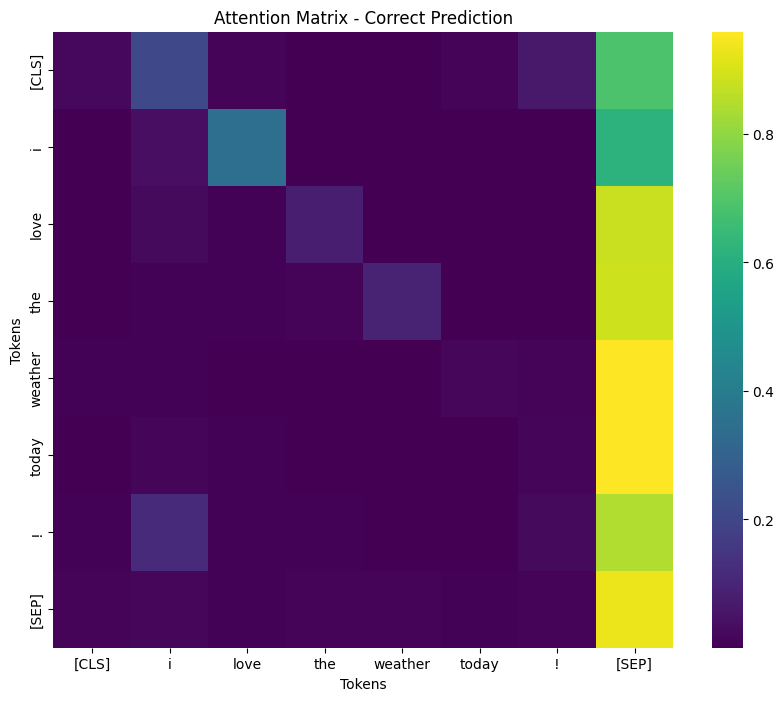

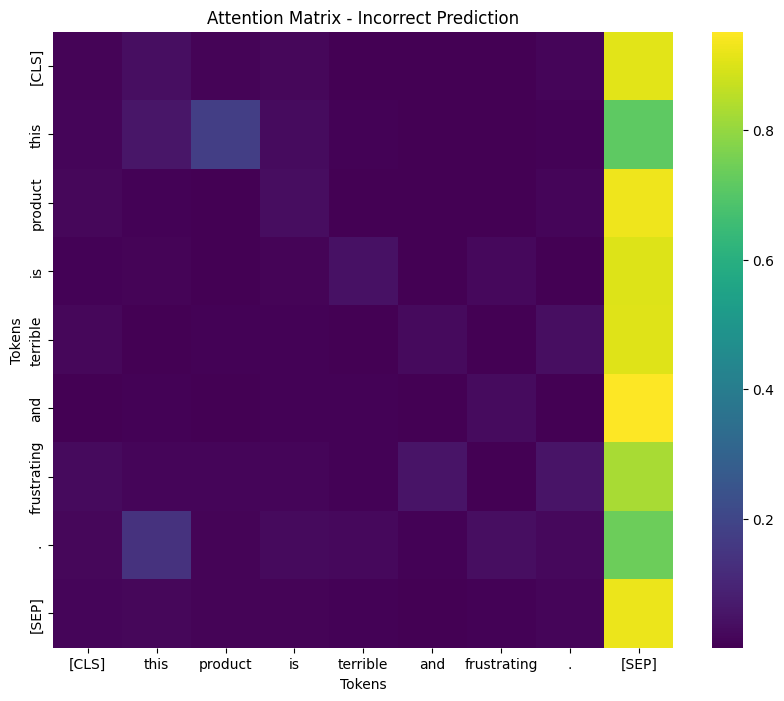

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Decode tokenized inputs for labels
tokens_correct = tokenizer.convert_ids_to_tokens(inputs_correct["input_ids"][0])
tokens_incorrect = tokenizer.convert_ids_to_tokens(inputs_incorrect["input_ids"][0])

# Function to plot attention
def plot_attention(attention_matrix, tokens, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(title)
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.show()

# Plot attention for correct and incorrect examples
plot_attention(attention_correct, tokens_correct, "Attention Matrix - Correct Prediction")
plot_attention(attention_incorrect, tokens_incorrect, "Attention Matrix - Incorrect Prediction")
